# Monitor Potato leaves by using Pre Trained Model

Use Pre trained Model is used to build a  Deep Learning Network to classify an image 
as part of Inference. 

Touched on 01/06/2021

In [1]:
# Import required libraries
import os
import uuid
import shutil
import json
#from botocore.client import Config
#import ibm_boto3
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

2023-04-08 19:42:38.687618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 19:42:41.285938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-08 19:42:41.285988: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-08 19:42:50.076804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

327 ..total number of images ( files)

In [2]:
!ls data


eb1compress  healthyv1	lb1compress  smpl.JPG


## Use MobileNetV2 Model as a Base Model

We start with a [MobileNetV2](https://arxiv.org/abs/1801.04381) architecture as the backbone [pretrained feature extractor](https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet). We then add a couple of dense layers and a softmax layer to perfom the classification. We freeze the MobileNetV2 backbone with weights trained on ImageNet dataset and only train the dense layers and softmax layer that we have added.

In [3]:
base_model=tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 1
x=tf.keras.layers.Dense(256,activation='relu')(x) #dense layer 2
preds=tf.keras.layers.Dense(3,activation='softmax')(x) #final layer with softmax activation

model=tf.keras.Model(inputs=base_model.input,outputs=preds)


2023-04-08 19:43:41.300786: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-08 19:43:41.300912: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-08 19:43:41.300983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jkhome): /proc/driver/nvidia/version does not exist
2023-04-08 19:43:41.313020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9406464/9406464 [==============================] - 2s 0us/step


In [4]:
#Freeze layers from MobileNetV2 backbone (not to be trained)
for layer in base_model.layers:
    layer.trainable=False

In [5]:
#Prepare the training dataset as a data generator object
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('data',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=10,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 326 images belonging to 3 classes.


###  Optimization
Using Adam, categorical_crossentropy and accuracy as optimization method, loss function and metrics, respectively

In [6]:
# Build the model
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()

## Train Deep Learning Model 

In [7]:
#tf.random.set_random_seed(1)
tf.random.set_seed(1)
#model.fit(X, y, epochs=150, batch_size=10)



In [8]:
step_size_train=5
#log_file = model.fit_generator(generator=train_generator,
#                   steps_per_epoch=step_size_train,
#                   epochs=4)
model.fit(train_generator, epochs=5, batch_size=10)

Epoch 1/5


2023-04-08 19:45:03.621120: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2023-04-08 19:45:03.943558: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2023-04-08 19:45:03.984783: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 16056320 exceeds 10% of free system memory.
2023-04-08 19:45:04.040801: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 48168960 exceeds 10% of free system memory.
2023-04-08 19:45:04.122160: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 49032960 exceeds 10% of free system memory.


33/33 [==============================] - 34s 794ms/step - loss: 0.3686 - accuracy: 0.8650
Epoch 2/5
33/33 [==============================] - 37s 1s/step - loss: 0.0728 - accuracy: 0.9724
Epoch 3/5
33/33 [==============================] - 36s 1s/step - loss: 0.0242 - accuracy: 0.9908
Epoch 4/5
33/33 [==============================] - 27s 805ms/step - loss: 0.0043 - accuracy: 1.0000
Epoch 5/5
33/33 [==============================] - 22s 662ms/step - loss: 0.0012 - accuracy: 1.0000


##  Model Performance 

Figure of Training Loss and Accuracy.

Perform inference on some sample data points to determine the performance of trained model.


In [9]:
# Mapping labels 
label_map = (train_generator.class_indices)

In [10]:
label_map

{'eb1compress': 0, 'healthyv1': 1, 'lb1compress': 2}

In [11]:
model.save('jkvision/1')

INFO:tensorflow:Assets written to: jkvision/1/assets


INFO:tensorflow:Assets written to: jkvision/1/assets


In [12]:
# Creating a sample inference function
def prediction(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    preds = model.predict(x)
    #print('Predictions', preds)
    
    for pred, value in label_map.items():    
        if value == np.argmax(preds):
            print('Predicted class is:', pred)
            print('With a confidence score of: ', np.max(preds))
    
    return np.argmax(preds)

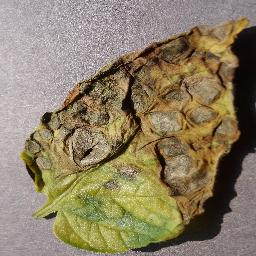

In [15]:
image = Image.open("data/smpl.JPG")
image

In [17]:
#performing inference on above image
prediction('data/smpl.JPG', model)

1/1 [==============================] - 3s 3s/step
Predicted class is: eb1compress
With a confidence score of:  0.99992025


0

In [18]:
#model.save("jj3Model.h5")
tf.keras.models.save_model(model,'/home/jk/dev/OnlineSource/DataSet/jj9Model.h5')


User can give file name and path. Above is a sample illustration of file name jj9Model.h5 and its path in Local PC or server